# Superdroplet Breakup: CPU Demo

Created by Emily de Jong, 20 May 2021

## 0. Install instructions

Be sure that an up-to-date version of Python3 is installed in order to build and run this package. Download the source code from: https://github.com/edejong-caltech/PySDM/tree/edj-Breakup, or install using suggested steps below.

Build the module. Be sure all requirements are install and up to date.

Tests and examples that use breakup can be found in "../PySDM_tests", including this notebook.

You can view all the contributions that I have made to this code base by comparing it to the original: https://github.com/atmos-cloud-sim-uj/PySDM

## 1. Background

PySDM is an existing superdroplet-method code that can handle many sets of particle processes, excluding breakup. The purpose of this project is to add a breakup-type process to the codebase for future research and testing. I extend the current implementation of particle coalescence to include breakup as well, with the following algorithm (my contributions and changes marked in green).

1. Randomly order the existing list of superdroplets, and generate a random number for collision probability.

2. Group the ordered list of superdroplets into pairs.

3. a) Compute the probability of a collision, based on collision kernel
      - <span style='color:green'> In the new version, coalescence and breakup take an additional argument: coalescence efficiency $E_c$. This required a minor modification to the backend and front end for "PySDM/dynamics/coalescence.py" and a new module "PySDM/physics/coalescence_efficiences.py". </span>
      - As in the literature, coalescence proceeds with rate $K(x,y)E_c$ and breakup with rate $K(x,y)(1-E_c)$ where $K(x,y)$ is the rate of collisions between particles of size $x$ and $y$.

   b) <span style='color:green'> Compute the number of fragments resulting from collisional breakup. Included are two example fragmentation functions: "PySDM/physics/breakup_fragmentations/slams.py" and ".../alwaysn.py". </span>
   
4. Compute $\gamma$, the number of collisions that lead to <span style='color:green'> breakup </span> (rather than to coalescence).

5. Perform the breakup step.
   

#### <span style='color:green'> Breakup step </span>  

The breakup step that updates particle attributes, which is called from "dynamics/breakup.py" and "state/particles.py", is based on the backend kernel for coalescence with modifications to include the fragmentation. The CPU backend source code is found in <span style='color:green'> "backends/numba/impl/_algorithmic_methods.py" </span>. The steps are as follows:

- If $\gamma = 0$, no collision; continue
- Else, for particles $j, k$ with multiplicities $n[j]$ and $n[k]$ and extrinsic attributes $a[j]$ and $a[k]$, find the new number of particles $n'[j] = n[j] - \gamma n[k]$

- If $n'[j] > 0$, update the attributes and particle counts:
    * $n[j]$ = $n'[j]$, $a[j]$ unchanged
    * $n[k]$ = $n[k] * n_{fragment}$
    * $a[k]$ = $\frac{a[k] + \gamma a[j]}{n_{fragment}}$
- Else split the resulting single droplet $a[k]$ into two superdroplets with equal attributes and half the multiplicity.

- If any SD multiplicities are zero, flag them.

## 2. Demonstration: Breakup alone

The following demonstrates an initial droplet population in a zero-D "Box" that undergoes only breakup.

In [3]:
import sys
import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius#, KMoments
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import Golovin
#from PySDM.physics.coalescence_efficiencies import Berry1967 
from PySDM.physics.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'threadsafe'

@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**4
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1e-3 / si.second)
        #self.breakup_kernel = ConstantK(a=100000 * si.cm**3 / si.second)
        self.breakup_kernel = Golovin(b = 200000 / si.second)
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

0
[27.2305955] [99.998]
1
[25.07102204] [149.997]
2
[22.47424233] [224.995497]


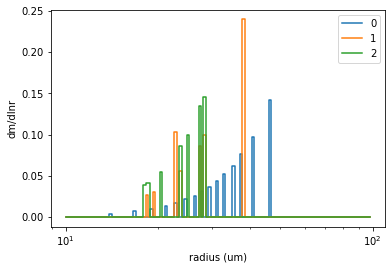

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.breakup_kernel, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
#coalescence = Coalescence(settings.breakup_kernel, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend([0, 1, 2])

Notice that after one second (orange), at least one superdroplet has fragmented leading to a set of smaller droplets. At even later times, more superdroplets have fragmented and there is a cluster of very small droplets.

## 3. Demonstration: Breakup and Coalescence

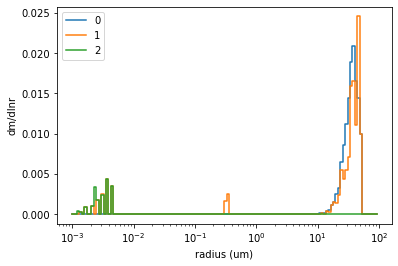

In [19]:
from PySDM.dynamics import Coalescence

settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ]
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')#, label="t = {step*settings.dt}s")
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

In this example we see that in the first simulation second, some larger droplets are formed via coalescence at the same time as some smaller fragments are formed from breakup. In the next time step, most of the droplets have fragmented leading to mainly smaller droplets.